# Keto Recipe Analysis

1. Recreate the conditions needed to determine if a recipe is more or less keto-friendly. 
1. Understand the ingredients from the recipes that are more keto-friendly from the titles of the recipes. 
1. _[Future State]_ Determine if it's possible to re-work recipes to be more keto-friendly from this understanding of ingredients in a recipe.

## Dataset

This dataset is from a scraped set of recipes from Epicurious and posted to Kaggle. The dataset was transformed from a JSON object into a CSV with recipe titles, ratings, some nutritional information, and some ingredients and tags as categories. 

In [1]:
# get the standard modules
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# get the data and load into pandas
# since this list has >20K recipes, it's ok to drop empty sets and duplicates
# take a quick look 
df_raw = pd.read_csv('epi_r.csv').dropna().drop_duplicates()
df_raw.head()

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,The Best Blts,4.375,948.0,19.0,79.0,1042.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


That's a lot of extra columns. It looks like the non-nutrient columns are categories and ingredients. That could be useful in the future after determining the level of "keto" for a specific recipe and returning the title. For now, narrow down the data set to the main indicators: rating / calories / protein / fat / sodium. In addition, assume the nutritional information is per serving size, since this is standard for most recipes.

### Cleaning and Adding to the Data

In [3]:
# assume the recipes will need to be cleaned
recipes_raw = df_raw.iloc[:,:6]
recipes_raw.head()

,title,rating,calories,protein,fat,sodium
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0
4,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0
5,The Best Blts,4.375,948.0,19.0,79.0,1042.0


What can I learn from this set of recipes?

In [4]:
recipes_raw.describe()

,rating,calories,protein,fat,sodium
count,14446.000000,1.444600e+04,14446.000000,1.444600e+04,1.444600e+04
mean,3.763585,6.647251e+03,92.380728,3.634952e+02,6.598615e+03
std,1.273693,3.755075e+05,3514.670388,2.136066e+04,3.490797e+05
min,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
25%,3.750000,2.060000e+02,3.000000,8.000000e+00,9.000000e+01
50%,4.375000,3.460000e+02,9.000000,1.800000e+01,3.060000e+02
75%,4.375000,6.010000e+02,28.000000,3.400000e+01,7.340000e+02
max,5.000000,3.011122e+07,236489.000000,1.722763e+06,2.767511e+07


Keto Analysis needs carbohydrates and this is missing from the nutritional information. _Luckily_ there is a good formula for getting carbs given calories, protein, and fat.

Given that: 

```Fat = 9 calories per gram```

```Protein = 4 calories per gram```

```Carbs = 4 calories per gram```

Carbs per recipe:

```def carbs(x): (calories - (protein * 4) - (fat * 9))/4```

In [5]:
recipes_raw['carbs'] = (recipes_raw['calories'] - (recipes_raw['protein'] * 4) - (recipes_raw['fat'] * 9))/4
recipes_raw.head()

,title,rating,calories,protein,fat,sodium,carbs
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,60.75
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,31.00
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,19.50
4,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,44.75
5,The Best Blts,4.375,948.0,19.0,79.0,1042.0,40.25


Run some boxplots to understand the data. Then run some correlations to understand the relationships with rating and calories/protein/fat/carbs.

rating         Axes(0.125,0.125;0.110714x0.755)
calories    Axes(0.257857,0.125;0.110714x0.755)
protein     Axes(0.390714,0.125;0.110714x0.755)
fat         Axes(0.523571,0.125;0.110714x0.755)
sodium      Axes(0.656429,0.125;0.110714x0.755)
carbs       Axes(0.789286,0.125;0.110714x0.755)
dtype: object

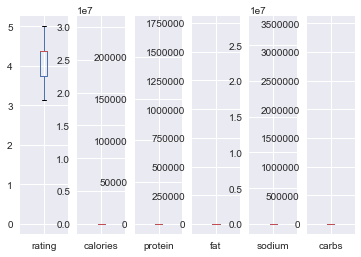

In [6]:
recipes_raw.plot(kind="box",subplots=1)

### More Cleaning and Description

The outliers from the dataset is skewing the analysis in a bad way. Dropping recipes that are more than two standard deviations from the mean (more than 95%) sounds like a good idea. But going to check what the data looks like first.

In [7]:
recipes_raw.sort_values(by='calories')
recipes_raw.nlargest(10, 'calories')

,title,rating,calories,protein,fat,sodium,carbs
11391,Pear-Cranberry Mincemeat Lattice Pie,4.375,30111218.0,200968.0,1722763.0,27675110.0,3450619.75
6368,Deep-Dish Wild Blueberry Pie,4.375,29997918.0,200210.0,1716279.0,27570999.0,3437641.75
19672,"Apricot, Cranberry and Walnut Pie",4.375,13062948.0,87188.0,747374.0,12005810.0,1496957.50
2976,Lamb Köfte with Tarator Sauce,5.000,4518216.0,166471.0,44198.0,7540990.0,863637.50
1304,"Rice Pilaf with Lamb, Carrots, and Raisins",5.000,4157357.0,236489.0,221495.0,3134853.0,304486.50
6912,Chocolate-Almond Pie,3.125,3358273.0,58334.0,186660.0,3449512.0,361249.25
5138,Caramelized Apple and Pear Pie,3.125,3358029.0,58324.0,186642.0,3449373.0,361238.75
16208,Merguez Lamb Patties with Golden Raisin Couscous,4.375,54512.0,2074.0,595.0,3983.0,10215.25
8192,Grilled Lamb Chops with Porcini Mustard,5.000,24117.0,940.0,2228.0,4382.0,76.25
8873,Grilled Cumin Chicken Breasts with Avocado Salsa,3.750,22312.0,332.0,1007.0,13820.0,2980.25


Yup, recipes in the millions of calories seem very wrong. Assume the nutritional information was incorrectly parsed from the original recipe pages, so let's just drop the extremes.

In [8]:
# check the values for the 95th percentile
recipes_raw.quantile(0.95)

rating         5.00
calories    1329.25
protein       76.00
fat           86.00
sodium      2061.00
carbs         99.50
Name: 0.95, dtype: float64

In [9]:
# filter out the rows that are greater than or equal to the 95th percentile
recipes = recipes_raw[recipes_raw['calories'] < recipes_raw['calories'].quantile(0.95)]
# and summarize
recipes.describe()

,rating,calories,protein,fat,sodium,carbs
count,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000,13723.000000
mean,3.753507,402.943453,17.039277,22.022007,619.057495,34.147071
std,1.280404,274.317384,21.386924,19.759945,2852.672366,29.348275
min,0.000000,0.000000,0.000000,0.000000,0.000000,-3.500000
25%,3.750000,200.000000,3.000000,8.000000,82.000000,11.500000
50%,4.375000,328.000000,8.000000,17.000000,281.000000,27.500000
75%,4.375000,550.000000,24.000000,31.000000,667.000000,48.250000
max,5.000000,1327.000000,234.000000,135.000000,132220.000000,276.750000


In [10]:
# check the maximum calorie values of the cleaner recipes dataset
recipes.nlargest(10, 'calories')

,title,rating,calories,protein,fat,sodium,carbs
4388,Wild Turkey Glazed Ribs,3.750,1327.0,73.0,107.0,1896.0,18.00
9210,"Rib-Eye Steaks with Mushrooms, Brandy and Blue...",4.375,1324.0,75.0,103.0,1152.0,24.25
17462,Oven-Roasted Dungeness Crab,4.375,1324.0,170.0,60.0,2853.0,26.00
9210,"Rib-Eye Steaks with Mushrooms, Brandy and Blue...",4.375,1324.0,75.0,103.0,1152.0,24.25
17462,Oven-Roasted Dungeness Crab,4.375,1324.0,170.0,60.0,2853.0,26.00
16294,Apple Cake with Maple-Walnut Cream Cheese Fros...,4.375,1322.0,15.0,82.0,720.0,131.00
5445,Lamb and Broccoli Stew,3.750,1321.0,56.0,103.0,17544.0,42.50
7682,Beef Short Ribs with Asian Flavors,3.750,1321.0,47.0,112.0,653.0,31.25
5445,Lamb and Broccoli Stew,3.750,1321.0,56.0,103.0,17544.0,42.50
7682,Beef Short Ribs with Asian Flavors,3.750,1321.0,47.0,112.0,653.0,31.25


On the right track. No idea why this function is printing the same values twice, but oh well. 

Repeat this for sodium next, since the maximum sodium value seems scary.

In [11]:
# check out what those salt recipes look like
recipes.nlargest(15, 'sodium')

,title,rating,calories,protein,fat,sodium,carbs
3275,Whole Branzino Roasted in Salt,5.000,417.0,53.0,20.0,132220.0,6.25
16190,Red Snapper Baked in Salt with Romesco Sauce,4.375,425.0,49.0,20.0,132025.0,12.25
10625,Baked Oysters with Bacon,0.000,443.0,29.0,24.0,116178.0,27.75
538,Whole Fish Baked in Sea Salt,5.000,553.0,48.0,38.0,97225.0,4.75
11697,Scallops with Mushrooms in White-Wine Sauce,4.375,190.0,9.0,13.0,90572.0,9.25
11069,Grilled Salmon in Corn Husks,3.750,1210.0,43.0,99.0,67909.0,36.75
7631,Chipotle Fried Onion Rings,3.750,714.0,45.0,37.0,67884.0,50.25
16672,Salt-Baked Salmon with Citrus and Herbs,3.750,1234.0,131.0,74.0,67253.0,11.00
13117,Herb-Brined Turkey with Pear Gravy,3.750,1291.0,163.0,60.0,66833.0,24.75
3272,Baked Sea Bass in Herbed Salt Crust,3.750,398.0,47.0,5.0,55097.0,41.25


From the title of the recipes, it is likely counting the overall sodium from the ingredients versus sodium intake per serving. While not extremely important, it's worth dropping sodium outliers too so the data is not horribly skewed. 

In [12]:
recipes = recipes[recipes['sodium'] < recipes['sodium'].quantile(0.95)]
# reset the index since values were filtered
recipes.reset_index(drop=True,inplace=True)
# and preview 
recipes.head(10)

,title,rating,calories,protein,fat,sodium,carbs
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,60.75
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,31.00
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,19.50
3,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,44.75
4,The Best Blts,4.375,948.0,19.0,79.0,1042.0,40.25
5,Korean Marinated Beef,4.375,170.0,7.0,10.0,1272.0,13.00
6,Ham Persillade with Mustard Potato Salad and M...,3.750,602.0,23.0,41.0,1696.0,35.25
7,"Yams Braised with Cream, Rosemary and Nutmeg",3.750,256.0,4.0,5.0,30.0,48.75
8,Banana-Chocolate Chip Cake With Peanut Butter ...,4.375,766.0,12.0,48.0,439.0,71.50
9,Beef Tenderloin with Garlic and Brandy,4.375,174.0,11.0,12.0,176.0,5.50


In [13]:
# summary statistics of the cleaner dataset
recipes.describe()

,rating,calories,protein,fat,sodium,carbs
count,13036.000000,13036.000000,13036.000000,13036.000000,13036.000000,13036.000000
mean,3.751342,389.428813,15.582387,21.403191,389.606321,33.617636
std,1.279428,262.487203,19.334197,19.246641,396.707667,28.870476
min,0.000000,0.000000,0.000000,0.000000,0.000000,-3.500000
25%,3.750000,198.000000,3.000000,7.000000,74.000000,11.250000
50%,4.375000,318.000000,8.000000,17.000000,252.000000,27.250000
75%,4.375000,528.000000,22.000000,30.000000,591.000000,47.750000
max,5.000000,1324.000000,183.000000,135.000000,1736.000000,276.250000


Awesome, filtering the miscalculated high-calorie recipes removed most of the extremes for high-protein recipes. 

**Wait, the minimum value of carbs is negative.** That doesn't make sense. Checking out these values.

In [14]:
recipes.nsmallest(5, 'carbs')

,title,rating,calories,protein,fat,sodium,carbs
5056,To Make Lobster Oil,3.750,489.0,2.0,55.0,40.0,-3.50
6438,Salad Niçoise with Mint-Lemon Dressing,3.750,722.0,1.0,81.0,42.0,-2.75
5065,Clarified Indian Butter,3.750,270.0,0.0,31.0,4.0,-2.25
7531,Indian Clarified Butter,4.375,270.0,0.0,31.0,4.0,-2.25
5065,Clarified Indian Butter,3.750,270.0,0.0,31.0,4.0,-2.25
7531,Indian Clarified Butter,4.375,270.0,0.0,31.0,4.0,-2.25
6488,Clarified Butter,1.875,271.0,0.0,31.0,4.0,-2.00
8243,Indian Clarified Butter (Ghee),4.375,271.0,0.0,31.0,4.0,-2.00
8657,Black Olive Aïoli,1.250,338.0,1.0,38.0,39.0,-2.00
11743,Crab-and-Pork Spring Rolls,5.000,1231.0,6.0,135.0,150.0,-2.00


From the original calculation for carbs, the assumptions about the calories from fat and protein were based on the total calories for recipes that _always_ a proportionate amount of protein. Dressings, sauces, butter, oil, and fried foods, to name a few, will have higher fat than protein. Since it is actually very important to surface recipes that have high-fat, I'll just set any recipes with carbs less than 0 to 0 instead. 

In [15]:
for k, v in recipes.iterrows():
    if recipes.loc[k, 'carbs'] < 0:
        recipes.set_value(k,'carbs', 0)

In [16]:
# check one of the known < 0 carb recipes
recipes.loc[8657]

title       Black Olive Aïoli 
rating                    1.25
calories                   338
protein                      1
fat                         38
sodium                      39
carbs                        0
Name: 8657, dtype: object

Looking better. Reset the index again to have a tidy set and run summary statistics. 

In [17]:
recipes.reset_index(drop=True,inplace=True)
recipes.head(20)

,title,rating,calories,protein,fat,sodium,carbs
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,60.75
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,31.00
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,19.50
3,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,44.75
4,The Best Blts,4.375,948.0,19.0,79.0,1042.0,40.25
5,Korean Marinated Beef,4.375,170.0,7.0,10.0,1272.0,13.00
6,Ham Persillade with Mustard Potato Salad and M...,3.750,602.0,23.0,41.0,1696.0,35.25
7,"Yams Braised with Cream, Rosemary and Nutmeg",3.750,256.0,4.0,5.0,30.0,48.75
8,Banana-Chocolate Chip Cake With Peanut Butter ...,4.375,766.0,12.0,48.0,439.0,71.50
9,Beef Tenderloin with Garlic and Brandy,4.375,174.0,11.0,12.0,176.0,5.50


In [18]:
recipes.describe()

,rating,calories,protein,fat,sodium,carbs
count,13036.000000,13036.000000,13036.000000,13036.000000,13036.000000,13036.00000
mean,3.751342,389.428813,15.582387,21.403191,389.606321,33.62314
std,1.279428,262.487203,19.334197,19.246641,396.707667,28.86394
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,3.750000,198.000000,3.000000,7.000000,74.000000,11.25000
50%,4.375000,318.000000,8.000000,17.000000,252.000000,27.25000
75%,4.375000,528.000000,22.000000,30.000000,591.000000,47.75000
max,5.000000,1324.000000,183.000000,135.000000,1736.000000,276.25000


### Re-check the distribution of the data across the ratings and nutrients.

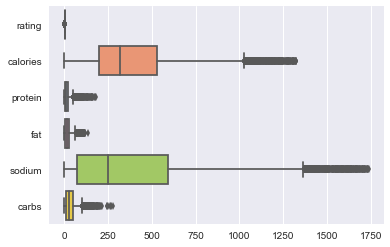

In [19]:
ax = sns.boxplot(data=recipes, orient="h", palette="Set2")

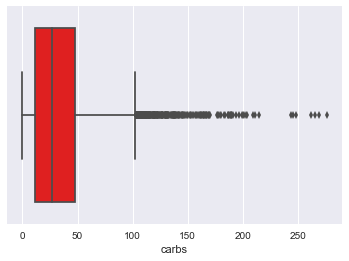

In [20]:
carbs = sns.boxplot(data=recipes, x="carbs", color="red")

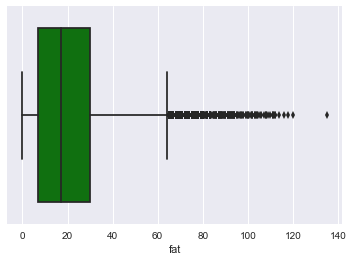

In [21]:
fat = sns.boxplot(data=recipes, x="fat",color="green")

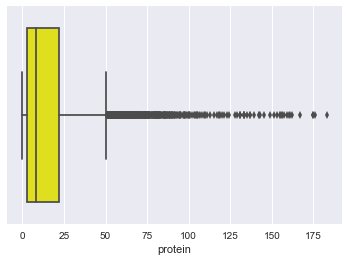

In [22]:
protein = sns.boxplot(data=recipes, x="protein",color="yellow")

### Understand Correlation of Nutritional Information

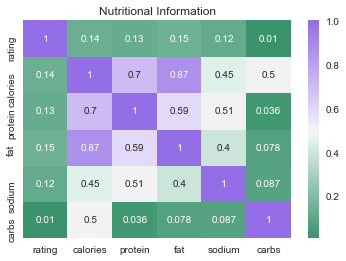

In [23]:
corr = recipes.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
graph = sns.diverging_palette(150, 275, s=80, l=55, n=9, as_cmap=True)
ax = plt.axes()
ax.set_title('Nutritional Information')
sns_plot = sns.heatmap(corr, annot=True, cmap=graph, ax = ax)
sns_plot.get_figure().savefig("correlation.png")

Not surprisingly, higher ratings is collinear with higher protein, fat, and calories. 

The typical keto ratio for a recipe is 85% of calories from fat, 20% of calories from protein and 5% of calories from carbs.

Plot how these recipes are currently distributed. 

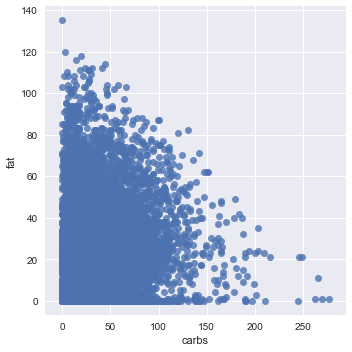

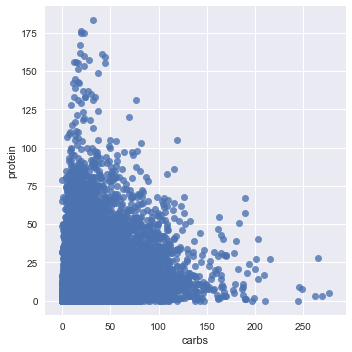

In [24]:
g_fat = sns.lmplot(x="carbs",y="fat",data=recipes,fit_reg=False)
g_fat.savefig("carbs-fat.png")
g_protein = sns.lmplot(x="carbs",y="protein",data=recipes,fit_reg=False)
g_protein.savefig("carbs-protein.png")

Decent clusters of lower-carb and high-protein and high-fat recipes. That's a good sign! Time to unpack the main variables and predict whether the recipe is keto-friendly given the above measurements.

## Keto or Not

Build the logistic regression model to classify these recipes, starting with a smaller sample as a training set. 

In [25]:
headers = list(recipes.columns.values)
print headers

['title', 'rating', 'calories', 'protein', 'fat', 'sodium', 'carbs']


In [26]:
features = ['calories','protein','fat','carbs']
train, test = train_test_split(recipes[features], train_size=0.7)
print train.shape, test.shape

(9125, 4) (3911, 4)


In [27]:
train.head()

,calories,protein,fat,carbs
10465,308.0,8.0,9.0,48.75
10536,687.0,37.0,44.0,35.75
12033,867.0,47.0,58.0,39.25
8203,298.0,2.0,1.0,70.25
9091,634.0,40.0,29.0,53.25


In [28]:
test.head()

,calories,protein,fat,carbs
11053,141.0,4.0,12.0,4.25
1247,335.0,22.0,13.0,32.50
10405,1126.0,55.0,88.0,28.50
3167,575.0,7.0,37.0,53.50
10748,375.0,38.0,20.0,10.75


In [29]:
for k, v in train.iterrows():
    if ((train.loc[k, 'fat'] * 9 ) / train.loc[k,'calories'] >= 0.85) or (
        (train.loc[k, 'carbs'] * 4) / train.loc[k, 'calories'] <= 0.12):
        train.loc[k, 'keto'] = 1
    else:
        train.loc[k, 'keto'] = 0

/Users/nancy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/Users/nancy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


In [30]:
#print len(train)
train.head(10)

,calories,protein,fat,carbs,keto
10465,308.0,8.0,9.0,48.75,0.0
10536,687.0,37.0,44.0,35.75,0.0
12033,867.0,47.0,58.0,39.25,0.0
8203,298.0,2.0,1.0,70.25,0.0
9091,634.0,40.0,29.0,53.25,0.0
11221,681.0,10.0,34.0,83.75,0.0
12627,537.0,18.0,46.0,12.75,1.0
10525,294.0,2.0,0.0,71.50,0.0
1606,104.0,0.0,0.0,26.00,0.0
737,96.0,2.0,6.0,8.50,0.0


In [31]:
keto_recipes = train[train['keto'] == 1]
keto_recipes.describe()

,calories,protein,fat,carbs,keto
count,1523.000000,1523.000000,1523.000000,1523.000000,1523.0
mean,470.465529,28.221930,36.445174,7.424327,1.0
std,303.065979,28.005361,23.445412,6.649781,0.0
min,8.000000,0.000000,1.000000,0.000000,1.0
25%,237.500000,5.000000,19.000000,2.500000,1.0
50%,408.000000,21.000000,31.000000,5.750000,1.0
75%,649.500000,43.000000,50.000000,10.250000,1.0
max,1324.000000,183.000000,135.000000,35.750000,1.0


In [32]:
# check the index of the recipe with highest carbs
print keto_recipes['carbs'].idxmax(axis=1)

2339


In [33]:
# determine the original recipe
recipes.loc[2339]

title       Braised Lamb Shanks on Soft Polenta with Bay L...
rating                                                  4.375
calories                                                 1212
protein                                                    94
fat                                                        77
sodium                                                    533
carbs                                                   35.75
Name: 2339, dtype: object

Even though this recipe has a decent amount of carbs, the fat and protein balances it out enough to classify it as a keto recipe. Let's check the confidence level of this set overall.

In [34]:
train_means = train.groupby('keto').mean()
train_means

,calories,protein,fat,carbs
keto,,,,
0.0,367.225599,12.590502,17.936069,38.859741
1.0,470.465529,28.221930,36.445174,7.424327


In [35]:
train_var = train.groupby('keto').var()
train_var

,calories,protein,fat,carbs
keto,,,,
0.0,60824.658874,235.470364,267.493347,812.30455
1.0,91848.987477,784.300255,549.687367,44.21959


### Build the logistic regression model using training data.

In [36]:
X = train[features]
y = train['keto']
model = LogisticRegression(fit_intercept = False)
result = model.fit(X, y)

In [37]:
model.score(X, y)

0.99934246575342467

That's a very high level of confidence in this model. Possibly overfitting. Check on the coefficients next.

In [38]:
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

,0,1
0,calories,[-0.0337095845916]
1,protein,[0.857697836045]
2,fat,[1.97933908624]
3,carbs,[-5.28242293301]


That makes sense. Large increases in fat and large decreases in carbs corresponds to the likelihood of a keto-friendly recipe. 

In [39]:
model2 = LogisticRegression()
model2.fit(X, y = train['keto'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Let's see how it performs on the test set. 

In [40]:
predicted = model2.predict(test)
print predicted

[ 0.  0.  1. ...,  0.  0.  0.]


In [41]:
test['keto'] = predicted
test.head()

,calories,protein,fat,carbs,keto
11053,141.0,4.0,12.0,4.25,0.0
1247,335.0,22.0,13.0,32.50,0.0
10405,1126.0,55.0,88.0,28.50,1.0
3167,575.0,7.0,37.0,53.50,0.0
10748,375.0,38.0,20.0,10.75,1.0


In [42]:
model2.score(test[features], test['keto'])

1.0

In [43]:
probs = model2.predict_proba(test[features])
print probs

[[  5.11432291e-001   4.88567709e-001]
 [  1.00000000e+000   1.14853735e-047]
 [  6.10556050e-012   1.00000000e+000]
 ..., 
 [  1.00000000e+000   1.27643534e-069]
 [  1.00000000e+000   4.61118039e-129]
 [  1.00000000e+000   1.33126825e-079]]


/Users/nancy/anaconda/lib/python2.7/site-packages/sklearn/linear_model/base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


In [44]:
print predicted
print len(predicted)

[ 0.  0.  1. ...,  0.  0.  0.]
3911


In [45]:
# check out the predicted set of keto recipes
more_keto_recipes = test[test['keto'] == 1]
print len(more_keto_recipes)
print "---"
print more_keto_recipes.head()
print "---"
more_keto_recipes.describe()

696
---
       calories  protein   fat  carbs  keto
10405    1126.0     55.0  88.0  28.50   1.0
10748     375.0     38.0  20.0  10.75   1.0
7865      260.0      1.0  27.0   3.25   1.0
8905      508.0     37.0  37.0   6.75   1.0
12550     370.0      0.0  42.0   0.00   1.0
---


,calories,protein,fat,carbs,keto
count,696.000000,696.000000,696.000000,696.000000,696.0
mean,475.541667,28.021552,37.021552,7.599497,1.0
std,314.498904,28.411586,24.472292,6.790723,0.0
min,14.000000,0.000000,1.000000,0.000000,1.0
25%,221.500000,4.000000,19.000000,2.750000,1.0
50%,409.000000,21.000000,31.000000,6.000000,1.0
75%,666.250000,42.000000,52.000000,11.000000,1.0
max,1311.000000,175.000000,116.000000,35.250000,1.0


In [46]:
# merge the training and testing sets
recipe_results = pd.concat([keto_recipes, more_keto_recipes])
print recipe_results['carbs'].idxmax(axis=1)

2339


In [47]:
# quick check on this recipe from the original dataframe to identify
recipes.loc[2339]

title       Braised Lamb Shanks on Soft Polenta with Bay L...
rating                                                  4.375
calories                                                 1212
protein                                                    94
fat                                                        77
sodium                                                    533
carbs                                                   35.75
Name: 2339, dtype: object

Since I just verified the indices still match, I want to merge my two dataframes back together based on the indices and the title column. 

In [48]:
all_recipes = pd.concat([recipe_results, recipes['title']], axis=1, join='inner')
#print all_recipes.head(10)
all_recipes.describe()

,calories,protein,fat,carbs,keto
count,2219.000000,2219.000000,2219.000000,2219.000000,2219.0
mean,472.057684,28.159081,36.625958,7.479270,1.0
std,306.635817,28.127150,23.768245,6.693268,0.0
min,8.000000,0.000000,1.000000,0.000000,1.0
25%,229.500000,5.000000,19.000000,2.500000,1.0
50%,408.000000,21.000000,31.000000,5.750000,1.0
75%,656.000000,43.000000,51.000000,10.500000,1.0
max,1324.000000,183.000000,135.000000,35.750000,1.0


How does the data from keto recipes differ from the original set?

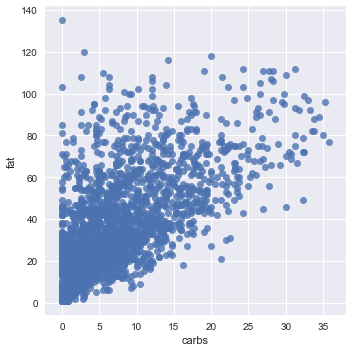

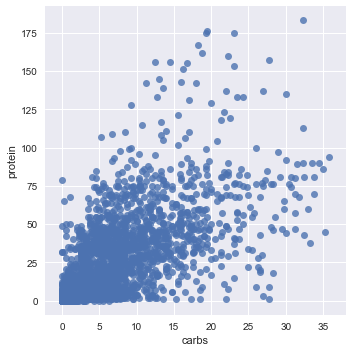

In [49]:
keto_fat = sns.lmplot(x="carbs",y="fat",data=all_recipes,fit_reg=False)
keto_cal = sns.lmplot(x="carbs",y="protein",data=all_recipes,fit_reg=False)
keto_fat.savefig("keto-carbs-fat.png")
keto_cal.savefig("keto-carbs-protein.png")

Overall, more variation in carbs but a big cluster in the low-carb zone, as expected!

In [50]:
all_recipes.nlargest(10, 'calories')

,calories,protein,fat,carbs,keto,title
6313,1324.0,75.0,103.0,24.25,1.0,"Rib-Eye Steaks with Mushrooms, Brandy and Blue..."
5315,1321.0,47.0,112.0,31.25,1.0,Beef Short Ribs with Asian Flavors
731,1320.0,77.0,110.0,5.50,1.0,Rib-Eye Steaks with Roasted Red Peppers and Ba...
3148,1315.0,142.0,78.0,11.25,1.0,Fennel-Dusted Chicken with Brown Butter and Ca...
7567,1311.0,90.0,98.0,17.25,1.0,Garlic Roast Pork
12051,1307.0,145.0,75.0,13.00,1.0,Microwave Chicken Piccata
2141,1305.0,175.0,57.0,23.00,1.0,Roast Turkey with White-Wine Gravy
2384,1305.0,92.0,100.0,9.25,1.0,Grilled Boneless Salmon Steaks with Horseradis...
9617,1305.0,100.0,89.0,26.00,1.0,Caramelized Chipotle Chicken
11218,1305.0,50.0,112.0,24.25,1.0,Sun-Dried Tomato and Garlic-Crusted Rack of Lamb


I am very confident in this list of recipes!

# Prediction to Themes

Now that I have a good list of keto recipes that I calculated, then used that training model to predict on a test set, it'll be interesting to see what themes are present in the keto recipes.

In [51]:
raw_titles = all_recipes['title']
#print titles

In [52]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features = 1000, 
                             ngram_range=(1, 2), 
                             stop_words='english',
                             binary=True)

titles = vectorizer.fit_transform(raw_titles)
titles.shape

(2219, 1000)

In [53]:
from gensim.models.ldamodel import LdaModel
from gensim.matutils import Sparse2Corpus
from wordcloud import WordCloud, STOPWORDS

id2word = dict(enumerate(vectorizer.get_feature_names()))
corpus = Sparse2Corpus(titles, documents_columns = False)
lda = LdaModel(corpus=corpus, id2word=id2word, num_topics=15)

#preview some topics
#dict(lda.show_topic(t, 200))

## Word Clouds!

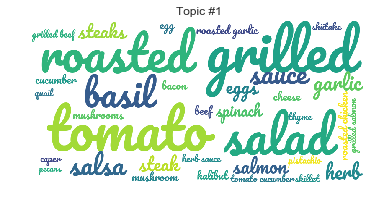

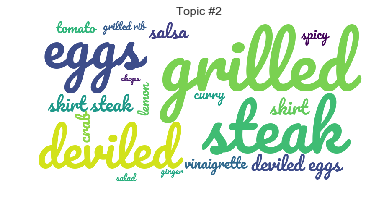

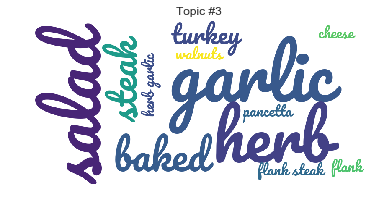

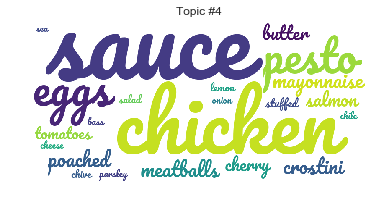

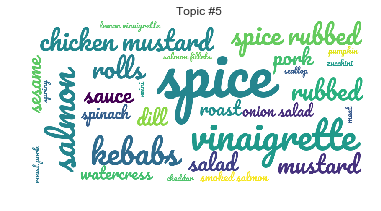

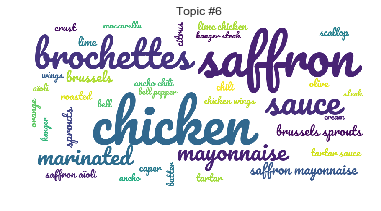

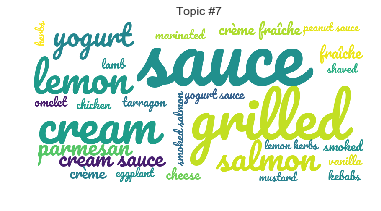

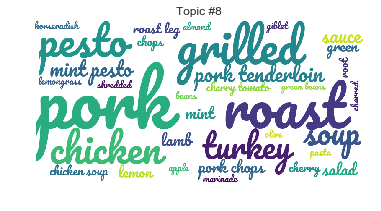

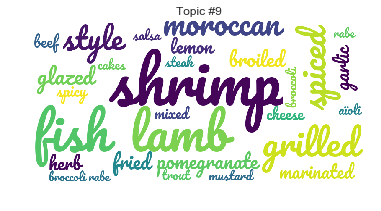

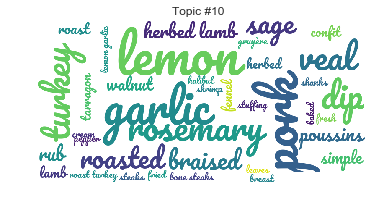

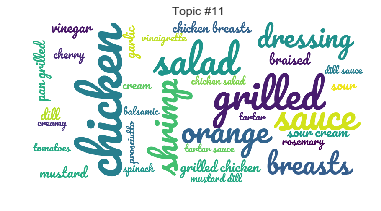

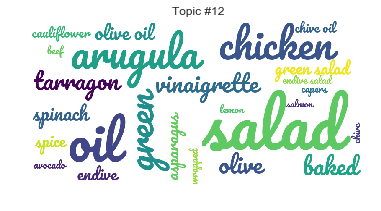

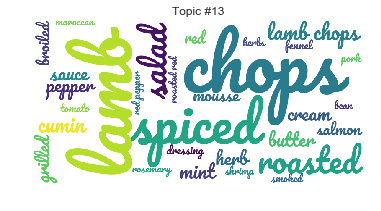

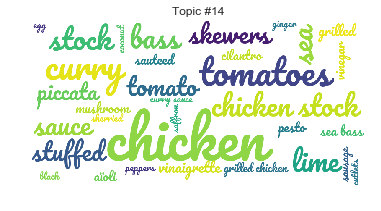

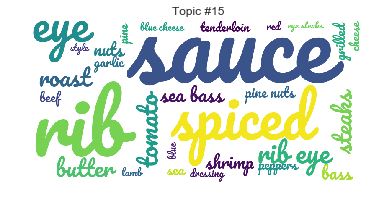

In [54]:
for t in range(lda.num_topics):
    plt.figure()
    plt.imshow(WordCloud(scale=2,
                         font_path='./Pacifico-Regular.ttf',
                         background_color='white',
                         min_font_size=10).fit_words(dict(lda.show_topic(t, 100))))
    plt.axis("off")
    item = (t+1)
    plt.title("Topic #{}".format(item))
    plt.savefig('./keto_themes_{}.png'.format(item), dpi=600)
    plt.show()

# Conclusion
Common themes for keto recipes are the usual suspects with protein: chicken, shrimp, sausage, chops. But it was surprising how many types of "sauces" there were: oil, vinaigrette, dip, salsa. Therefore, even if a recipe is less "keto" because it does not have a high amount of fat, as long as there is a low amount of carbs, people can supplement their recipes with lots of sauces.

## Next Steps
Next would be to understand what kinds of specific ingredients are represented in those keto recipes. Some of this is surfaced thanks to the LDA model and themes. But outputting a list, matching against existing recipes that are not as keto-friendly, and then determining what can be substituted in these recipes would open even more opportunity for a lengthy list of keto recipes.